In [10]:
import numpy as np # for working with arrays
import pandas as pd # for working with arrays and plotting data
from ipyfilechooser import FileChooser # for importing files
import matplotlib.pyplot as plt # for exporting plotted data

In [11]:
def remove_empty_col(data_df):
    # get the list of column names and its length
    col_names = data_df.columns
    initial_len = len(col_names)
   
    # check if there are empty columns (these are sometimes uninentionally imported)
    drop_unnamed_df = data_df.drop(list(data_df.filter(regex='Unnamed')), axis='columns')
    if ' ' in col_names:
        dropped_df = drop_unnamed_df.drop(' ', axis='columns')        
    
    else:
        dropped_df = drop_unnamed_df

    # get the new number of columns 
    new_len = len(dropped_df.columns)

    # print out how many columns were removed, if any
    print(f'{initial_len-new_len} empty column(s) removed. There are now {new_len} columns.')

    return(dropped_df)

def zero_curves(data_df):
    # define the start of association as zero by subtracting the initial row of values 
    zeroed_df = data_df - data_df.iloc[0].values.squeeze()
    # round time to one decimal place
    zeroed_df.Time = zeroed_df.Time.round(1)

    return(zeroed_df)

def remove_drop(data_df, end_ass=599.8, start_dis=602.0):

    # get the values for the end of association and the start of dissociation
    end_ass_vals   = data_df.query(f'{end_ass} == Time').reset_index(drop=True)
    start_dis_vals = data_df.query(f'{start_dis} == Time').reset_index(drop=True)
    
    # subtract the end of association from the start of dissociation to get the delta
    delta = start_dis_vals.subtract(end_ass_vals)
    # we don't want to subtract time, so set the delta for Time to zero
    delta['Time'] = 0

    # cut out the times between end_ass and start_dis (Time = end_ass and Time = start_dis are kept)
    # and stitch the start of dissociation to the end of association.
    corrected_df = pd.concat([data_df.query(f'0 <= Time <= {end_ass}'),
                              data_df.query(f'{start_dis} <= Time')-delta.values.squeeze()], 
                             ignore_index=True)

    return(corrected_df)

def control_correction(data_df):
    # subtract the controls: (NP - NP_control) - (protein - protein_control)
    # get column names from the dataframe
    col_names = data_df.columns
    
    # use a filter to get the NP columns
    NP_filter = filter(lambda a: 'NP' in a, col_names)
    NP_list   = list(NP_filter)
    
    # use a filter to get the analyte (serum or other protein) control columns
    prot_filter = filter(lambda a: 'A' in a, col_names)
    prot_list   = list(prot_filter)
    
    # subtract the NP control from each NP column, and the protein control from each protein column
    sub_df = pd.DataFrame()

    for i in NP_list:
        sub_df[i] = data_df[i]-data_df['NP 0']

    for i in prot_list:
        sub_df[i] = data_df[i]-data_df['A 0']
    
    # subtract the protein controls from the corresponding NP columns
    
    # create a new dataframe to contain the control subtracted data
    con_sub_df = pd.DataFrame()
    
    # create a time column for the new dataframe
    con_sub_df['Time'] = data_df['Time']
    
    for i in NP_list:
        # get the corresponding protein control column
        prot_conc = i.partition('NP ')[2]
        
        # subtract it from the NP column and insert it into the new dataframe
        con_sub_df[i] = sub_df[i]-sub_df[f'A {prot_conc}']

    return(con_sub_df)

def flip_curves(data_df,
                ass_time1 = 30.0,
                ass_time2 = 300.0, 
                dis_time1 = 700.0,
                dis_time2 = 1000.0,
                start_dis = 602.0
                ):
    # make a copy of the dataframe to modify
    flip_df = data_df
    
    # get column names from the dataframe, exclude time column (first column)
    col_names = flip_df.columns[1:]

    # Go through the columns and check if the association is in the correct orientation. 
    # If not, flip all of the data. Also, zero the data to the start of association.
    for i in col_names:
        ass_pt1 = flip_df.query(f'{ass_time1} == Time')[i].values.squeeze()
        ass_pt2 = flip_df.query(f'{ass_time2} == Time')[i].values.squeeze()
        
        # Check if asssociation increases, if decreasing --> flip
        if ass_pt1 > ass_pt2: 
            flip_df[i] = flip_df[i]*(-1)
    
#     Go through the columns and check if the association is in the correct orientation.
#     If not, flip the dissociation data. 
    
    for i in col_names:
        dis_pt1 = flip_df.query(f'{dis_time1} == Time')[i].values.squeeze()
        dis_pt2 = flip_df.query(f'{dis_time2} == Time')[i].values.squeeze()

        #Check if dissociation is decreasing, if increasing --> flip 
        if dis_pt1 < dis_pt2:
            dis_start = flip_df.query(f'{start_dis} == Time')[i].values.squeeze()
            dis_flip  = dis_start - (flip_df.query(f'{start_dis} <= Time')[i]-dis_start)
            
            flip_df[i].update(dis_flip)
    
    return(flip_df)

In [12]:
# Create and display a FileChooser widget to select the BLI data
fc = FileChooser()
display(fc)


FileChooser(path='/Users/benstordy/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofToronto/Zahra Sep…

In [13]:
# get the file path of the selected BLI file
file_path=str(fc.selected)
# get the parent folder the file is in
folder_path = file_path[:file_path.rfind('/')+1]
# create a pandas dataframe with the BLI data
bli_data = pd.read_csv(file_path)

0 empty column(s) removed. There are now 17 columns.


<Axes: xlabel='Time'>

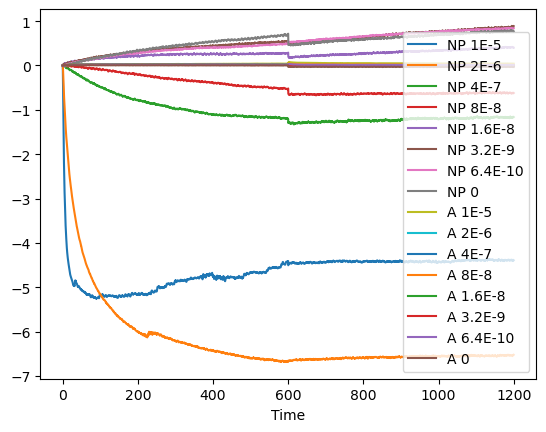

In [14]:
# drop any NaN rows
dropNArow_df = bli_data.dropna(axis='rows')
# drop any NaN columns
dropNAcol_df = dropNArow_df.dropna(axis='columns')
time_rounded_df = dropNAcol_df.round({'Time' : 1})
# remove any empty columns, if there are any
rm_col_df = remove_empty_col(time_rounded_df)
# print(rm_col_df.iloc[0].values.squeeze())
# zero the data to the start of association
rm_col_df_numeric = rm_col_df.apply(pd.to_numeric)
zero_df = zero_curves(rm_col_df_numeric)
zero_df.plot(x='Time')

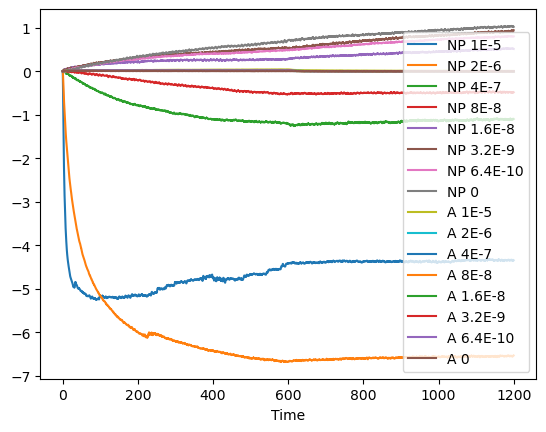

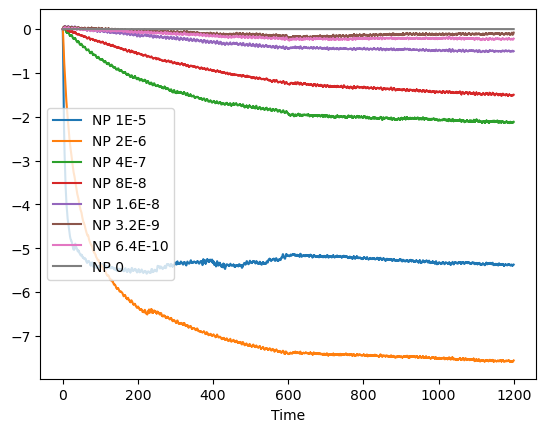

In [15]:
# set the end of association and start of dissociation times so that we can removing the 
# refractive index shift drop and stitch it together

# set_end_ass   = 119.8
# set_start_dis = 121.4
# 119.8 and 121.4 for 120 second association and dissociation phases

set_end_ass   = 599.8
set_start_dis = 601.4
# 599.8 and 601.4 for 600 second association and dissociation phases

# remove the RI shift drop
drop_rm_df = remove_drop(zero_df, end_ass = set_end_ass, start_dis = set_start_dis)
drop_rm_df.plot(x='Time')
# subtract the controls: (NP - NP_control) - (protein - protein_control)
con_sub_df = control_correction(drop_rm_df)
con_sub_df.plot(x='Time')
# flip the binding curves if necessary
flip_df = flip_curves(con_sub_df, 
                      ass_time1 = 2,
#                       ass_time2 = 80, # for 120s
#                       dis_time1 = 124, # for 120s
#                       dis_time2 = 140, # for 120s
                      ass_time2 = 200, # for 600s
                      dis_time1 = 609, # for 600s
                      dis_time2 = 800, # for 600s
                      start_dis = set_start_dis)

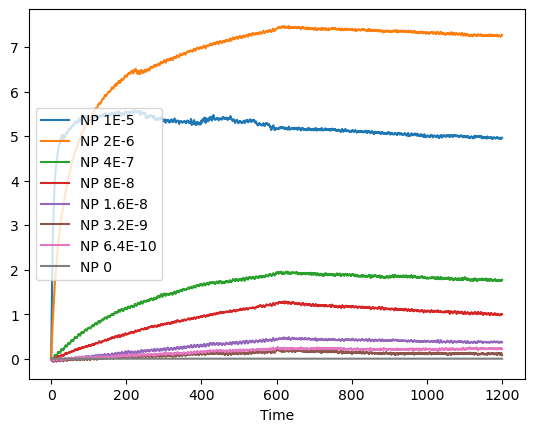

In [16]:
#plot the cleaned and processed data
flip_df.plot(x='Time')

# save a plot of the processed data in the same folder as the raw data, with the same name 
# but with "_processed" appended at the end of the file name
title = file_path[file_path.rfind('/')+1:file_path.rfind('.')]
plt.savefig(f'{folder_path}{title}_processed.pdf', format='pdf', bbox_inches='tight')

In [17]:
# save the processed file in the same folder as the raw data, with the same name 
# but with "processed_" appended at the start of the file name
folder_path = file_path[:file_path.rfind('/')+1]
title = file_path[file_path.rfind('/')+1:file_path.rfind('.')]

# remove the NP control column because it will always be just zeros
export_df = flip_df.drop('NP 0', axis='columns')

# export the processed data
export_df.to_csv(f'{folder_path}processed_{title}.csv', index=False)